# Superpixel and Morphology Postprocessing

In [9]:
import sys
import os
import cv2
import importlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Add the parent directory to the Python path
parent_dir = os.path.abspath(os.path.join('../..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [10]:
# SETUP

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from models import get_dfs, METAINFO, label_to_rgb

import pickle

with open('last_prediction.pkl', 'rb') as f:
    prediction = pickle.load(f)

with open('last_image.pkl', 'rb') as f:
    image = pickle.load(f)

with open('last_label.pkl', 'rb') as f:
    lbl = pickle.load(f)

In [4]:
# Function to compute IoU directly using RGB images
def compute_iou(pred_rgb, target_rgb, palette):
    num_classes = len(palette)
    ious = np.zeros(num_classes)
    for idx, color in enumerate(palette):
        pred_mask = np.all(pred_rgb == color, axis=-1)
        target_mask = np.all(target_rgb == color, axis=-1)

        tp = np.sum(pred_mask & target_mask)
        fp = np.sum(pred_mask & ~target_mask)
        fn = np.sum(~pred_mask & target_mask)
        union = tp + fp + fn

        # Avoid division by zero
        if union != 0:
            ious[idx] = tp / union
    return ious

# 1. Superpixel

(-0.5, 255.5, 255.5, -0.5)

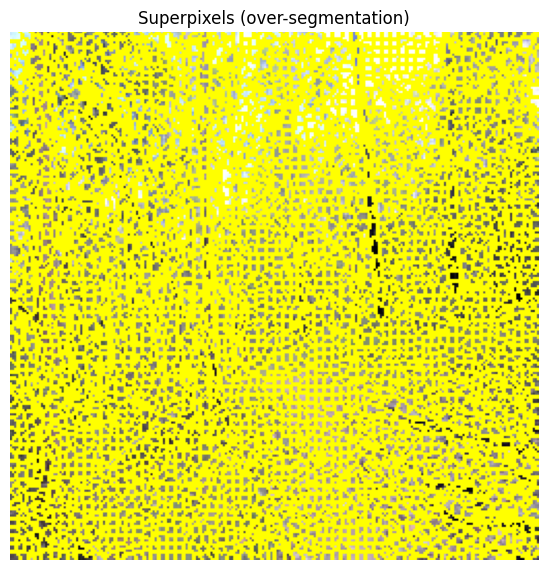

In [10]:
# SUPERPIXEL ALGORITHM
# from An Improved Semantic Segmentation Method Based on Superpixels and Conditional Random Fields
# (Zhao et al., 2019)
# https://www.mdpi.com/2076-3417/8/5/837

from skimage.segmentation import slic, mark_boundaries

# inputs:
# original image
# segmented image from segnet

# apply SLIC to segment the whole image into K superpixels: segments
segments = slic(image, n_segments=5000, compactness=10, start_label=1)
superpixel_img = mark_boundaries(image, segments).astype('float')

plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(superpixel_img)
plt.title("Superpixels (over-segmentation)")
plt.axis('off')

## Predictions Visualization

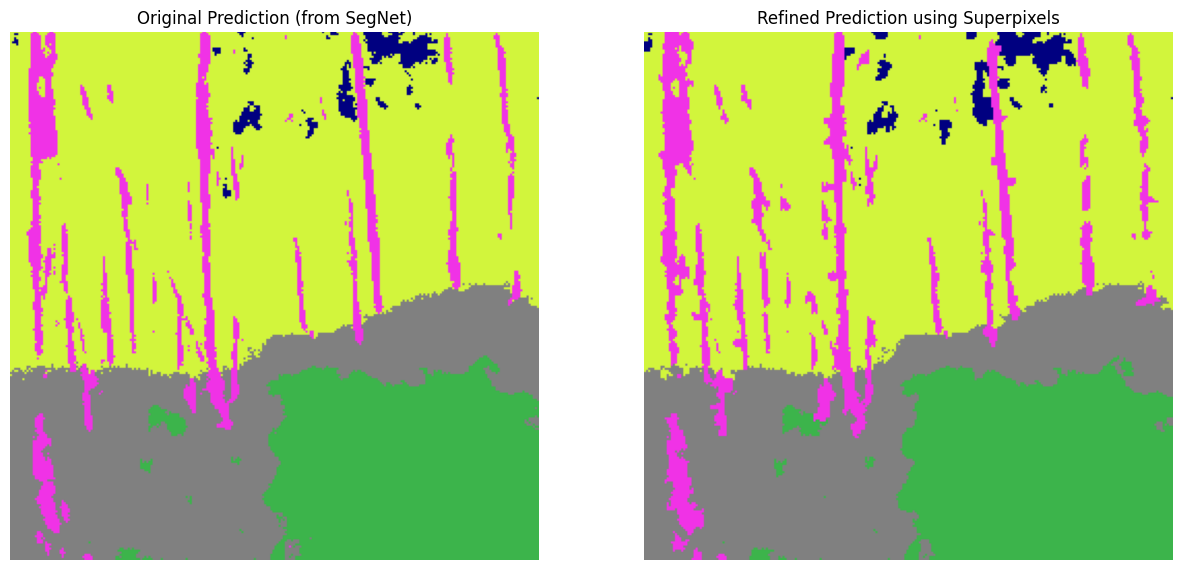

In [11]:
prediction_rgb = label_to_rgb(prediction, METAINFO['palette'])
prediction_new = prediction_rgb.copy()

# for each superpixel
for segment in np.unique(segments):
    N = np.count_nonzero(segment) # number of pixels in superpixel
    
    # count number of classes in segment
    segment_rgb = prediction_rgb[segments == segment]
    pixels = [tuple(colour) for colour in segment_rgb.reshape(-1, 3)]
    classes = list(set(pixels))
    num_classes = len(classes)

    # initialise all class weights with 0
    weights = {}
    for tup in classes:
        weights[tup] = 0

    # for each pixel
    for p in segment_rgb.reshape(-1, 3):
        pixel = tuple(p)

        # Wcj = oldWcj + 1/N
        weights[pixel] += (1 / num_classes)

        # if Wcj > 0.8, exit this inner loop
        if (weights[pixel] > 0.8):
            break

    # search maximum Wmax and sub-maximum Wsub
    curr_max = 0
    max_label = classes[0]
    for label in weights:
        if weights[label] > curr_max:
            curr_max = weights[label]
            max_label = label

    curr_sub = 0
    sub_max_label = classes[0]
    for label in weights:
        if weights[label] > curr_sub:
            if label != max_label:
                curr_sub = weights[label]
                sub_max_label = label

    # if Wmax - Wsub > 0.2, move onto next step
    if (sub_max_label != max_label and  curr_max - curr_sub > 0.2):
        # reassign classification of current superpixel with LCmax
        prediction_new[segments == segment] = max_label

plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(prediction_rgb)
plt.title("Original Prediction (from SegNet)")
plt.axis('off')
plt.subplot(122)
plt.imshow(prediction_new)
plt.title("Refined Prediction using Superpixels")
plt.axis('off')
plt.show()

### Without threshold

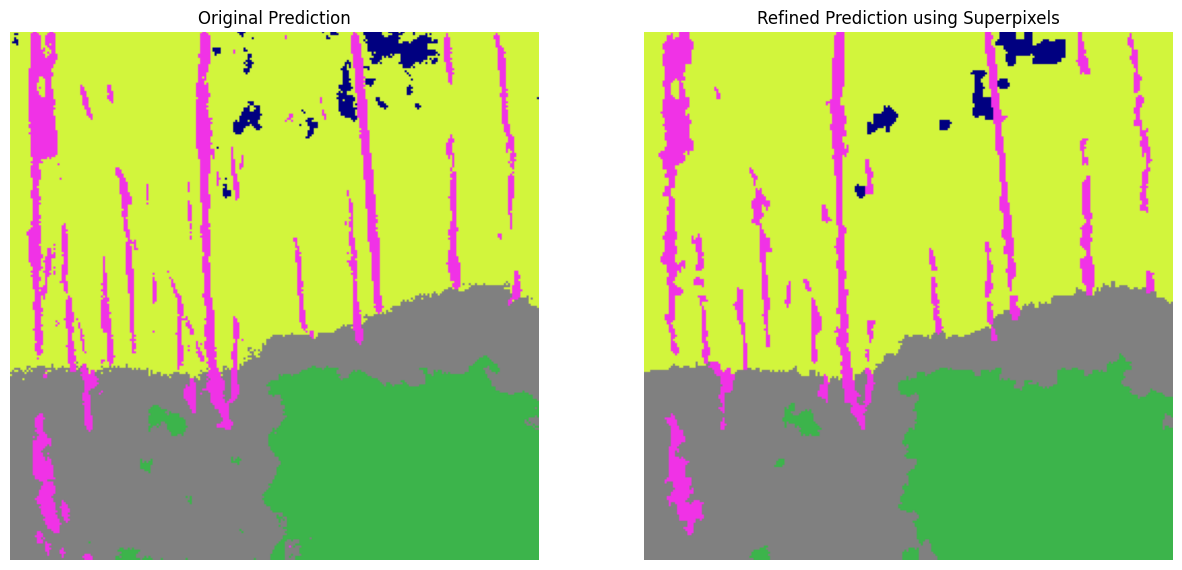

In [12]:
# Similar algorithm to above but without the 0.8 threshold (for comparison)
# assign each superpixel to the majority class of all its pixels (theoretically, each superpixel should represent one class)

prediction_new_2 = np.zeros_like(prediction_rgb)

for segment in np.unique(segments):
    N = np.count_nonzero(segment) # number of pixels in superpixel
    
    # count number of classes in segment
    segment_rgb = prediction_rgb[segments == segment]
    pixels = [tuple(colour) for colour in segment_rgb.reshape(-1, 3)]
    classes = list(set(pixels))
    num_classes = len(classes)

    # initialise all class weights with 0
    weights = {}
    for tup in classes:
        weights[tup] = 0

    # for each pixel
    for p in segment_rgb.reshape(-1, 3):
        pixel = tuple(p)

        # Wcj = oldWcj + 1/N
        weights[pixel] += (1 / num_classes)

    # search maximum Wmax
    curr_max = 0
    max_label = classes[0]
    for label in weights:
        if weights[label] > curr_max:
            curr_max = weights[label]
            max_label = label

    prediction_new_2[segments == segment] = max_label

plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(prediction_rgb)
plt.title("Original Prediction")
plt.axis('off')
plt.subplot(122)
plt.imshow(prediction_new_2)
plt.title("Refined Prediction using Superpixels")
plt.axis('off')
plt.show()

## IoU with Superpixel

In [13]:
num_classes = len(METAINFO['palette'])

# compare IOU of both of the above
iou = compute_iou(label_to_rgb(prediction, METAINFO['palette']), label_to_rgb(lbl, METAINFO['palette']), METAINFO['palette'])
print("IOU of original segmentation: ")
print(iou)
print("Average: ", np.sum(iou) / num_classes)
print()

iou = compute_iou(prediction_new, label_to_rgb(lbl, METAINFO['palette']), METAINFO['palette'])
print("IOU of segmentation with superpixel post-processing with threshold: ")
print(iou)
print("Average: ", np.sum(iou) / num_classes)
print()

iou = compute_iou(prediction_new_2, label_to_rgb(lbl, METAINFO['palette']), METAINFO['palette'])
print("IOU of segmentation with superpixel post-processing without threshold: ")
print(iou)
print("Average: ", np.sum(iou) / num_classes)

IOU of original segmentation: 
[          0           0     0.86519           0           0           0           0     0.32474     0.74534           0           0           0           0           0           0           0           0     0.38467     0.62881]
Average:  0.15519739974522923

IOU of segmentation with superpixel post-processing with threshold: 
[          0           0     0.86184           0           0           0           0     0.33868     0.73673           0           0           0           0           0           0           0           0     0.38591     0.63122]
Average:  0.1554934669310063

IOU of segmentation with superpixel post-processing without threshold: 
[          0           0     0.87141           0           0           0           0     0.30735     0.74209           0           0           0           0           0           0           0           0     0.35329     0.63374]
Average:  0.15304598100257197


# 2. Closing

## Prediction Visualization

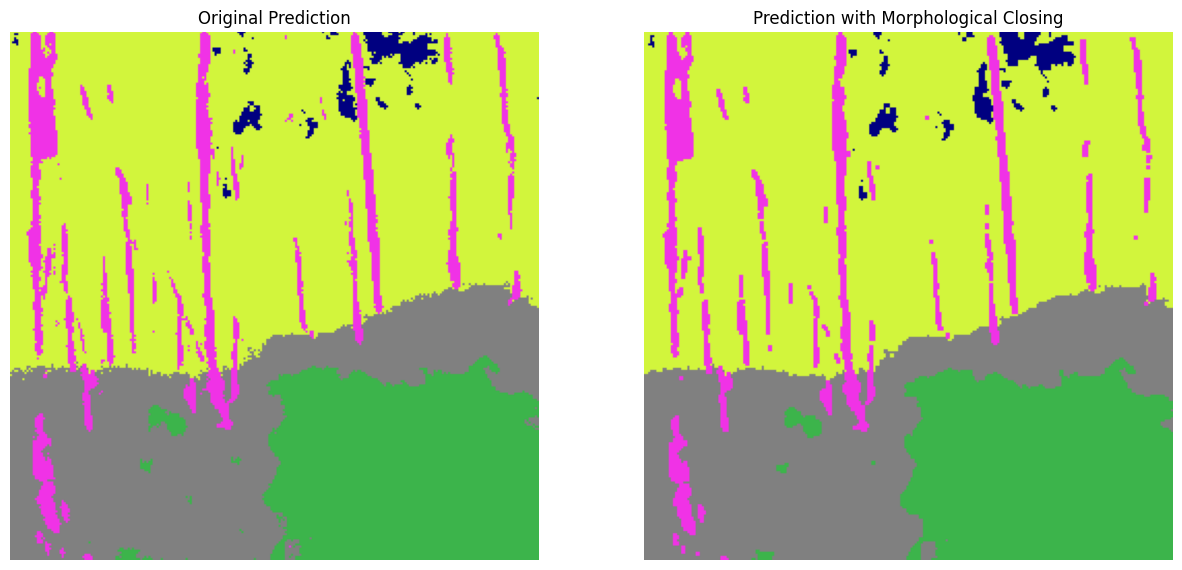

In [14]:
# Morphological Operators
# close up very small holes using 2x2 kernel
import cv2
from scipy.spatial import KDTree

kernel = np.ones((2, 2), np.uint8)
closed = cv2.morphologyEx(prediction.astype(np.uint8), cv2.MORPH_CLOSE, kernel)

plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(label_to_rgb(prediction, METAINFO['palette']))
plt.title("Original Prediction")
plt.axis('off')

plt.subplot(122)
plt.imshow(label_to_rgb(closed, METAINFO['palette']))
plt.title("Prediction with Morphological Closing")
plt.axis('off')
plt.show()


## IoU scores with Closing

In [15]:
# Check iou
iou = compute_iou(label_to_rgb(prediction, METAINFO['palette']), label_to_rgb(lbl, METAINFO['palette']), METAINFO['palette'])
print("IOU of original segmentation: ")
print(iou)
print("Average: ", np.sum(iou) / num_classes)
print()

iou = compute_iou(label_to_rgb(closed, METAINFO['palette']), label_to_rgb(lbl, METAINFO['palette']), METAINFO['palette'])
print("IOU of segmentation with morphological closing: ")
print(iou)
print("Average: ", np.sum(iou) / num_classes)

IOU of original segmentation: 
[          0           0     0.86519           0           0           0           0     0.32474     0.74534           0           0           0           0           0           0           0           0     0.38467     0.62881]
Average:  0.15519739974522923

IOU of segmentation with morphological closing: 
[          0           0     0.86656           0           0           0           0     0.30781     0.73918           0           0           0           0           0           0           0           0     0.37415     0.63659]
Average:  0.15391041521448334


# 3. Tree Trunks

## Predictions Visualization

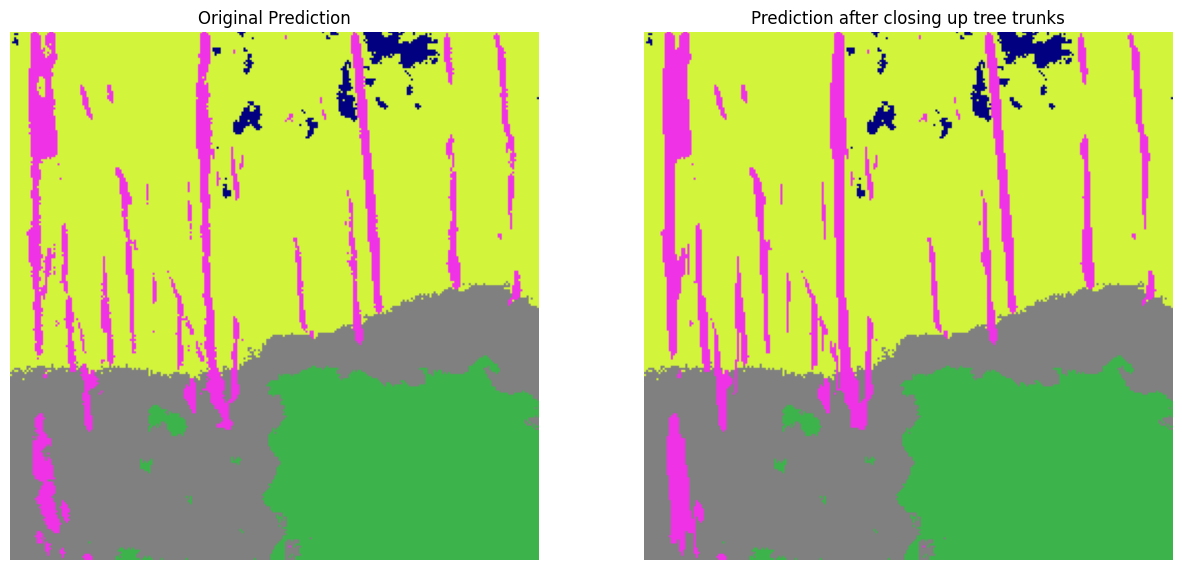

In [16]:
# Tree Trunks (closing gaps in tree trunks)

trunk_colour = (240, 50, 230)
threshold = 15

pred_new2 = label_to_rgb(prediction, METAINFO['palette']).copy()

height, width, _ = pred_new2.shape

for i in range(width):
    last_pink_row = None
    for j in range(height):
        if (tuple(label_to_rgb(prediction, METAINFO['palette'])[j, i]) == trunk_colour):
            if last_pink_row != None and 0 < j - last_pink_row <= threshold:
                for y in range(last_pink_row + 1, j):
                    pred_new2[y, i] = trunk_colour
            last_pink_row = j

plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(label_to_rgb(prediction, METAINFO['palette']))
plt.title("Original Prediction")
plt.axis('off')

plt.subplot(122)
plt.imshow(pred_new2)
plt.title("Prediction after closing up tree trunks")
plt.axis('off')
plt.show()

## IoU Scores

In [17]:
# Check iou
iou = compute_iou(label_to_rgb(prediction, METAINFO['palette']), label_to_rgb(lbl, METAINFO['palette']), METAINFO['palette'])
print("IOU of original segmentation: ")
print(iou)
print("Average: ", np.sum(iou) / num_classes)
print()

iou = compute_iou(pred_new2, label_to_rgb(lbl, METAINFO['palette']), METAINFO['palette'])
print("IOU of segmentation with morphological closing: ")
print(iou)
print("Average: ", np.sum(iou) / num_classes)

IOU of original segmentation: 
[          0           0     0.86519           0           0           0           0     0.32474     0.74534           0           0           0           0           0           0           0           0     0.38467     0.62881]
Average:  0.15519739974522923

IOU of segmentation with morphological closing: 
[          0           0     0.86519           0           0           0           0     0.34682     0.74829           0           0           0           0           0           0           0           0     0.38467     0.63425]
Average:  0.1568004695584319


# 3. Conditional Random Field

In [ ]:
import models.postprocessing.crf

for i in range(0, 5):
    crf_res = crf.crf_main(image, pred_new2, i)

    plt.figure(figsize=(10, 10))
    plt.subplot(121)
    plt.imshow(pred_new2)
    plt.title("Prediction")
    plt.axis('off')

    plt.subplot(122)
    plt.imshow(crf_res)
    plt.title(f"Prediction + CRF (n={i})")
    plt.axis('off')
    
    plt.show()

In [1]:
import crf

# Adjusting gaussian size
for i in range(1, 5):
    crf_res = crf.crf_custom(image, pred_new2, 1, gaussian_size=i)
    
    
    plt.figure(figsize=(10, 10))
    plt.subplot(141)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(142)
    plt.imshow(label_to_rgb(lbl, METAINFO['palette']))
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(144)
    plt.imshow(pred_new2)
    plt.title("Prediction")
    plt.axis('off')

    plt.subplot(144)
    plt.imshow(crf_res)
    plt.title(f"Prediction + CRF (n={i})")
    plt.axis('off')
    
    plt.show()

NameError: name 'image' is not defined

5  labels  {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)}
Using generic 2D functions


/Users/Jennifer/anaconda3/envs/segnet/lib/python3.11/site-packages/pydensecrf/utils.py:159: RuntimeWarning: divide by zero encountered in divide
  mesh[i] /= s
/Users/Jennifer/anaconda3/envs/segnet/lib/python3.11/site-packages/pydensecrf/utils.py:159: RuntimeWarning: invalid value encountered in divide
  mesh[i] /= s


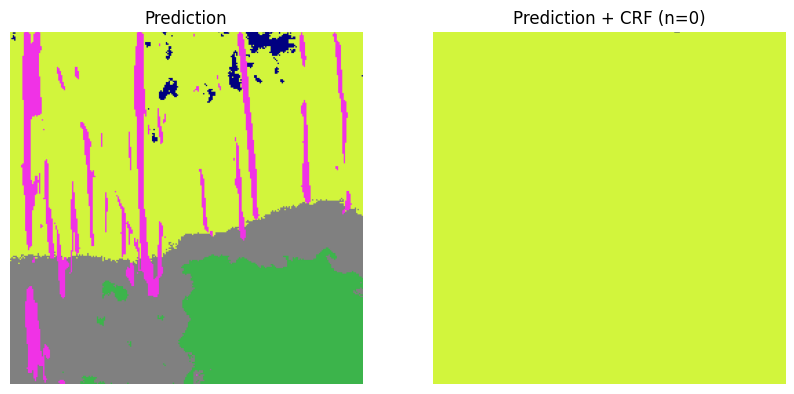

5  labels  {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)}
Using generic 2D functions


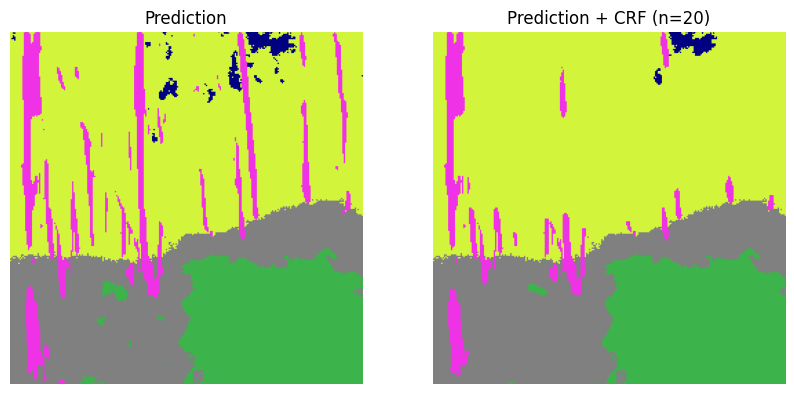

5  labels  {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)}
Using generic 2D functions


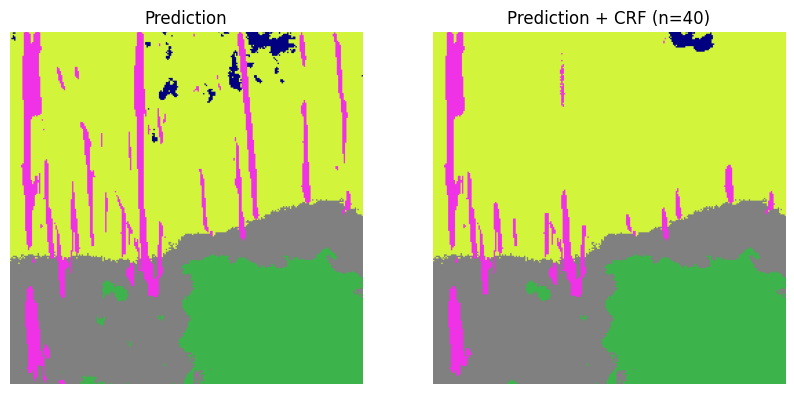

5  labels  {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)}
Using generic 2D functions


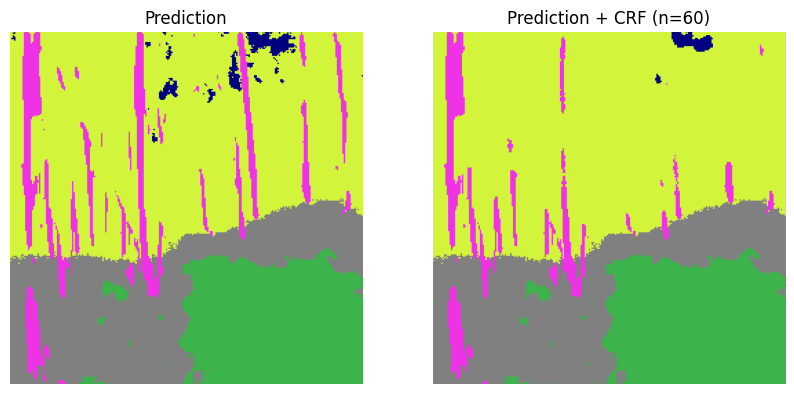

5  labels  {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)}
Using generic 2D functions


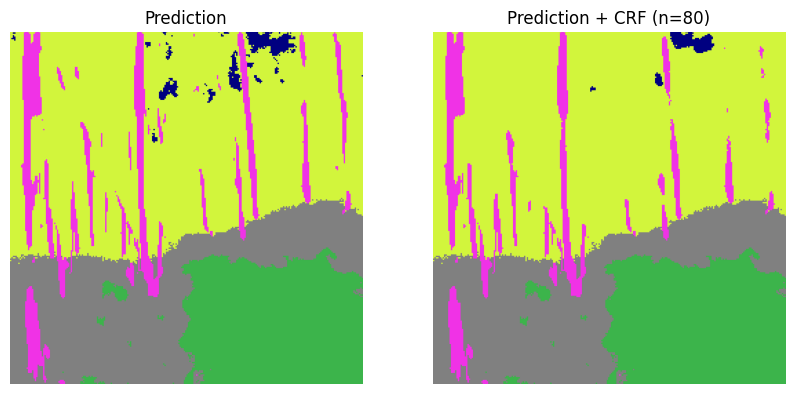

5  labels  {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)}
Using generic 2D functions


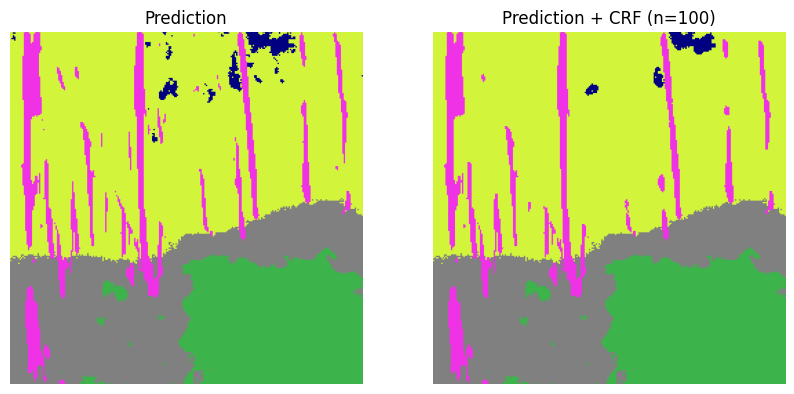

5  labels  {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)}
Using generic 2D functions


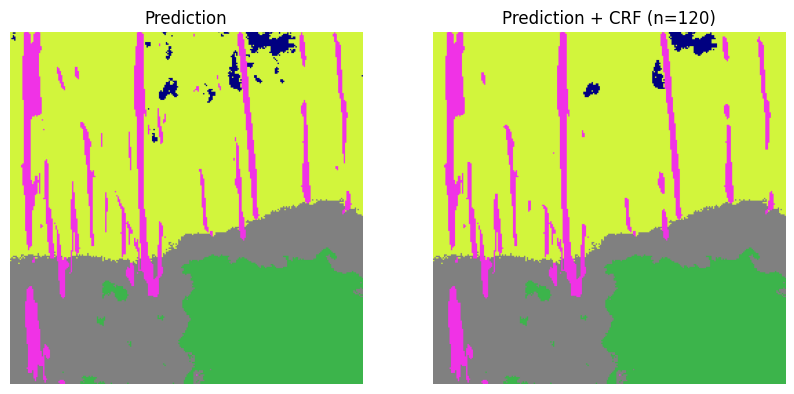

5  labels  {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)}
Using generic 2D functions


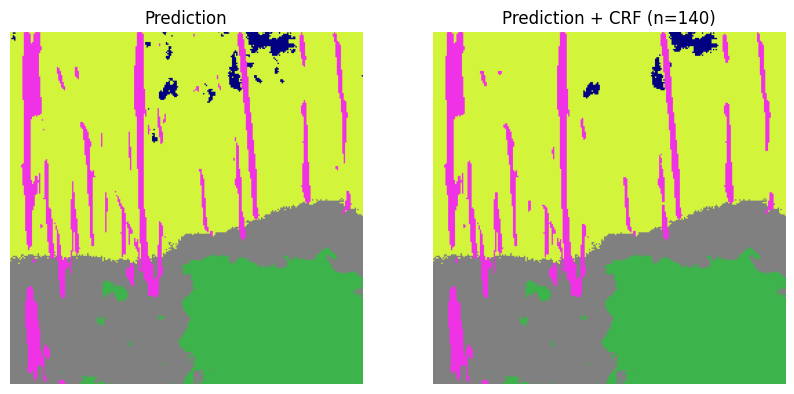

5  labels  {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)}
Using generic 2D functions


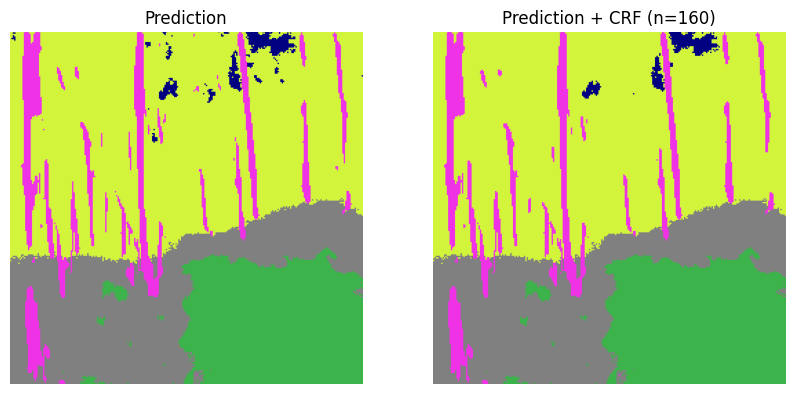

5  labels  {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)}
Using generic 2D functions


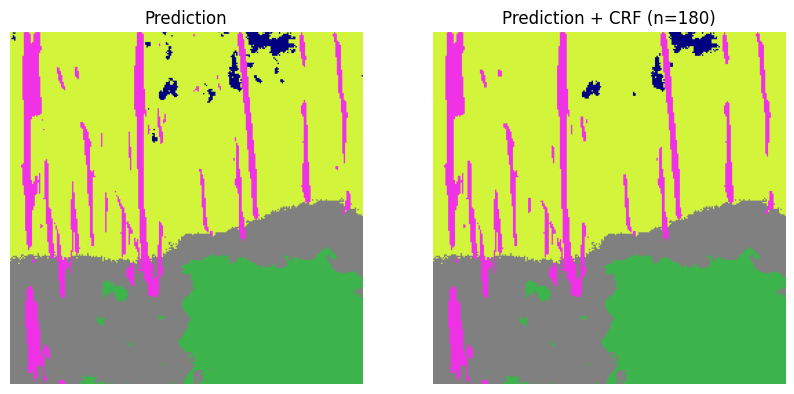

In [ ]:
import crf

# Adjusting bilaterial_size size
for i in range(0, 200, 20):
    crf_res = crf.crf_custom(image, pred_new2, 3, bilaterial_size=i)

    plt.figure(figsize=(10, 10))
    plt.subplot(131)
    plt.imshow(label_to_rgb(lbl, METAINFO['palette']))
    plt.title("Prediction")
    plt.axis('off')
    
    
    plt.subplot(132)
    plt.imshow(pred_new2)
    plt.title("Prediction")
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(crf_res)
    plt.title(f"Prediction + CRF (n={i})")
    plt.axis('off')
    
    plt.show()